Mohammed Ghori
* BAP Final Project - Tues Night 6-9 PM Section 60
* Professor Parkhi

## Dataset: https://www.kaggle.com/wyattowalsh/basketball

## Project Description
Predict how likely a team is to win a game based on various simple counting statistics at halftime. Many sports betting websites now allow players to place bets at halftime. With a small sample of data generated from the first half of the game, it may be wise to use this data as a "training set" to predict how the second half of the game would play out. Doing so can have applications in sports betting by being able to accurately predict a winner from halftime, leading to more accurate live betting odds and thus lower payouts from sports betting companies to lucky winners.

### Problem Statement
We can more accurately predict the outcome of an NBA basektball game using halftime data as our main predictor, leading to better outcomes for sports betting and more accurate betting lines which can save the betting companies money by reducing payouts from inaccurate betting lines.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
conect = sqlite3.connect(r"/Users/mohammedghori/Downloads/archive/basketball.sqlite")
print(conect)

In [57]:
# SQL Query
sql = "SELECT WL_HOME,WL_Away,PTS_QTR1_HOME,PTS_QTR2_HOME, PTS_QTR1_AWAY,PTS_QTR2_AWAY, AST_HOME, AST_AWAY, DREB_HOME, DREB_AWAY, OREB_HOME, OREB_AWAY, STL_HOME, STL_AWAY, FTA_HOME, FTA_AWAY, BLK_HOME, BLK_AWAY, TOV_HOME, TOV_AWAY FROM Game WHERE SEASON_ID >= '22018'"
dfhome = pd.read_sql(sql = sql, con = conect)

### About the Dataset

Contains data from NBA games since 2018-2019 season, including stats such as points, rebounds, assists, steals, turnovers, and blocks. Also contains a win/loss column for both the home and away team, marked by a "W" or an "L". Statistical data is all numeric. 

In [32]:
dfhome.head()

,WL_HOME,WL_AWAY,PTS_QTR1_HOME,PTS_QTR2_HOME,PTS_QTR1_AWAY,PTS_QTR2_AWAY,AST_HOME,AST_AWAY,DREB_HOME,DREB_AWAY,OREB_HOME,OREB_AWAY,STL_HOME,STL_AWAY,FTA_HOME,FTA_AWAY,BLK_HOME,BLK_AWAY,TOV_HOME,TOV_AWAY
0,W,L,31,26,23,24,28,21,41,29,17,16,7,12,18.0,37.0,7,6,21,15
1,W,L,21,26,21,21,21,18,43,41,12,6,7,8,14.0,23.0,5,5,15,16
2,W,L,31,25,23,29,22,20,33,32,19,14,3,9,29.0,27.0,4,2,12,11
3,W,L,23,49,24,25,21,19,36,38,10,7,12,7,31.0,18.0,6,3,16,24
4,W,L,37,19,24,22,35,28,38,28,6,10,5,7,16.0,20.0,2,5,12,9


In [33]:
dfhome.describe()

,FTA_HOME,FTA_AWAY
count,3374.000000,3374.000000
mean,22.903972,22.243628
std,7.410957,7.306425
min,2.000000,4.000000
25%,18.000000,17.000000
50%,23.000000,22.000000
75%,28.000000,27.000000
max,51.000000,54.000000


## Data Cleaning 
### 1. Finding and removing Nulls

In [34]:
# Check for nulls - they are present
dfhome.isnull().sum()

WL_HOME          40
WL_AWAY          40
PTS_QTR1_HOME     5
PTS_QTR2_HOME     5
PTS_QTR1_AWAY     5
PTS_QTR2_AWAY     5
AST_HOME          0
AST_AWAY          0
DREB_HOME         0
DREB_AWAY         0
OREB_HOME         0
OREB_AWAY         0
STL_HOME          0
STL_AWAY          0
FTA_HOME          0
FTA_AWAY          0
BLK_HOME          0
BLK_AWAY          0
TOV_HOME          0
TOV_AWAY          0
dtype: int64

In [35]:
# View the NAs
dfhome[dfhome["WL_HOME"].isnull()]
dfhome[dfhome["PTS_QTR1_HOME"].isnull()]

,WL_HOME,WL_AWAY,PTS_QTR1_HOME,PTS_QTR2_HOME,PTS_QTR1_AWAY,PTS_QTR2_AWAY,AST_HOME,AST_AWAY,DREB_HOME,DREB_AWAY,OREB_HOME,OREB_AWAY,STL_HOME,STL_AWAY,FTA_HOME,FTA_AWAY,BLK_HOME,BLK_AWAY,TOV_HOME,TOV_AWAY
2816,W,L,None,None,None,None,25,23,35,23,12,6,10,6,19.0,15.0,4,2,13,13
3114,L,W,None,None,None,None,28,33,25,41,11,7,12,4,19.0,13.0,2,6,8,21
3116,L,W,None,None,None,None,23,25,31,37,8,14,5,8,19.0,17.0,4,1,12,9
3154,L,W,None,None,None,None,28,30,30,34,7,10,5,7,24.0,28.0,2,2,13,13
3157,L,W,None,None,None,None,22,24,29,36,13,10,7,3,19.0,15.0,4,3,6,10


In [36]:
# Drop all rows that contain any NAs - missing important features, cannot recreate based on other data
dfhome.dropna(inplace=True)

### 2. Data Preparation - Correcting Data Types & Creating Features

In [37]:
# Convert str to int
dfhome[["PTS_QTR1_HOME", "PTS_QTR2_HOME"]] = dfhome[["PTS_QTR1_HOME", "PTS_QTR2_HOME"]].apply(pd.to_numeric)
dfhome[["PTS_QTR1_AWAY", "PTS_QTR2_AWAY"]] = dfhome[["PTS_QTR1_AWAY", "PTS_QTR2_AWAY"]].apply(pd.to_numeric)

In [38]:
# Create total points column
dfhome["Halftime Home"] = dfhome["PTS_QTR1_HOME"] + dfhome["PTS_QTR2_HOME"] 
dfhome["Halftime Away"] = dfhome["PTS_QTR1_AWAY"] + dfhome["PTS_QTR2_AWAY"]

# Create point differential column
dfhome["Point Differential"] = dfhome["Halftime Home"] - dfhome["Halftime Away"]

In [39]:
# Convert all stat columns to integers
dfhome[["PTS_QTR1_HOME", "PTS_QTR2_HOME", "AST_HOME", "AST_AWAY", "DREB_HOME", "DREB_AWAY", "OREB_HOME", "OREB_AWAY", "STL_HOME", "STL_AWAY", "FTA_HOME", "FTA_AWAY", "BLK_HOME", "BLK_AWAY", "TOV_HOME", "TOV_AWAY"]] = dfhome[["PTS_QTR1_HOME", "PTS_QTR2_HOME", "AST_HOME", "AST_AWAY", "DREB_HOME", "DREB_AWAY", "OREB_HOME", "OREB_AWAY", "STL_HOME", "STL_AWAY", "FTA_HOME", "FTA_AWAY", "BLK_HOME", "BLK_AWAY", "TOV_HOME", "TOV_AWAY"]].apply(pd.to_numeric)

In [40]:
# Creating differential columns

dfhome["Ast Differential"] = (dfhome["AST_HOME"] - dfhome["AST_AWAY"])/2
dfhome["DREB Differential"] = (dfhome["DREB_HOME"] - dfhome["DREB_AWAY"])/2
dfhome["OREB Differential"] = (dfhome["OREB_HOME"] - dfhome["OREB_AWAY"])/2
dfhome["Stl Differential"] = (dfhome["STL_HOME"] - dfhome["STL_AWAY"])/2
dfhome["FTA Differential"] = (dfhome["FTA_HOME"] - dfhome["FTA_AWAY"])/2
dfhome["Blk Differential"] = (dfhome["BLK_HOME"] - dfhome["BLK_AWAY"])/2
dfhome["Tov Differential"] = (dfhome["TOV_HOME"] - dfhome["TOV_AWAY"])/2

In [41]:
dfhome.head()

,WL_HOME,WL_AWAY,PTS_QTR1_HOME,PTS_QTR2_HOME,PTS_QTR1_AWAY,PTS_QTR2_AWAY,AST_HOME,AST_AWAY,DREB_HOME,DREB_AWAY,...,Halftime Home,Halftime Away,Point Differential,Ast Differential,DREB Differential,OREB Differential,Stl Differential,FTA Differential,Blk Differential,Tov Differential
0,W,L,31.0,26.0,23.0,24.0,28,21,41,29,...,57.0,47.0,10.0,3.5,6.0,0.5,-2.5,-9.5,0.5,3.0
1,W,L,21.0,26.0,21.0,21.0,21,18,43,41,...,47.0,42.0,5.0,1.5,1.0,3.0,-0.5,-4.5,0.0,-0.5
2,W,L,31.0,25.0,23.0,29.0,22,20,33,32,...,56.0,52.0,4.0,1.0,0.5,2.5,-3.0,1.0,1.0,0.5
3,W,L,23.0,49.0,24.0,25.0,21,19,36,38,...,72.0,49.0,23.0,1.0,-1.0,1.5,2.5,6.5,1.5,-4.0
4,W,L,37.0,19.0,24.0,22.0,35,28,38,28,...,56.0,46.0,10.0,3.5,5.0,-2.0,-1.0,-2.0,-1.5,1.5


In [42]:
# Create new dataframe with just relevant predictor features
df_new = dfhome.copy() 
df_new.drop(columns=["PTS_QTR1_HOME", "PTS_QTR2_HOME", "AST_HOME", "AST_AWAY", "DREB_HOME", "DREB_AWAY", "OREB_HOME", "OREB_AWAY", "STL_HOME", "STL_AWAY", "FTA_HOME", "FTA_AWAY", "BLK_HOME", "BLK_AWAY", "TOV_HOME", "TOV_AWAY"],inplace=True)
df_new.drop(["WL_HOME","WL_AWAY"],axis=1,inplace=True)
df_new.drop(["PTS_QTR1_AWAY","PTS_QTR2_AWAY","Halftime Home", "Halftime Away"],axis=1,inplace=True)

In [43]:
df_new.head() # 8 different attributes to base predictions on

,Point Differential,Ast Differential,DREB Differential,OREB Differential,Stl Differential,FTA Differential,Blk Differential,Tov Differential
0,10.0,3.5,6.0,0.5,-2.5,-9.5,0.5,3.0
1,5.0,1.5,1.0,3.0,-0.5,-4.5,0.0,-0.5
2,4.0,1.0,0.5,2.5,-3.0,1.0,1.0,0.5
3,23.0,1.0,-1.0,1.5,2.5,6.5,1.5,-4.0
4,10.0,3.5,5.0,-2.0,-1.0,-2.0,-1.5,1.5


Data Definitions: 
- Point Differential: difference in points scored between home and away team
- Ast Differential: difference in assists	
- DREB Differential: difference in rebounds secured on defense
- OREB Differential: difference in rebounds secured on offence	
- Stl Differential: difference in steals	
- FTA Differential: difference in the number of free throws attempted	
- Blk Differential: difference in blocks	
- Tov Differential: difference in turnovers

## Exploratory Data Analysis and Visualization


 W    0.56173
L    0.43827
Name: WL_HOME, dtype: float64


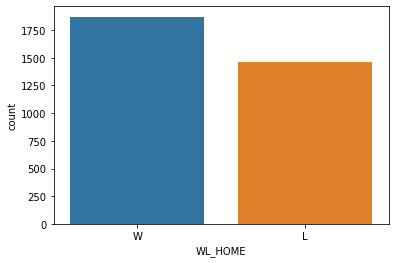

In [44]:
# Home Team Advantage
sns.countplot(x="WL_HOME",data=dfhome)
print('\n',dfhome["WL_HOME"].value_counts(normalize=True))

If both the home and away teams had no built-in advantage, we would expect that the winning proportion for each would be approximately 50/50. However, we can see here that home teams have a slight advantage over the away team - the well-known "home-court advantage" in basketball terms - since our data is built around the difference between home and away teams in various statistical categories, we should be aware of this bias.

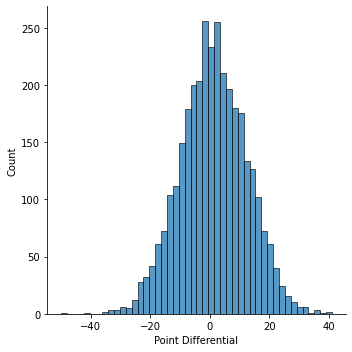

In [45]:
# Point differential (as measured Home - Away) is approximately normally distributed
sns.displot(dfhome["Point Differential"])

Point differential is approximately normally distributed.

In [46]:
dfhome[dfhome["Point Differential"].between(5,5)]["WL_HOME"].value_counts(normalize=True)

W    0.764151
L    0.235849
Name: WL_HOME, dtype: float64

Given just a 5-point lead at halftime, the home team is expected to win 76.4% of the time. This illustrates that point differential will likely be a very strong feature for this dataset in predicting W or L.

,Point Differential,Ast Differential,DREB Differential,OREB Differential,Stl Differential,FTA Differential,Blk Differential,Tov Differential
count,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000
mean,1.211475,0.416191,0.464254,0.123160,-0.085461,0.329528,0.099579,0.067588
std,11.246943,3.364840,3.753854,2.612752,1.981695,4.494104,1.746067,2.581793
min,-50.000000,-11.000000,-11.500000,-11.000000,-6.500000,-19.000000,-6.000000,-9.500000
25%,-6.000000,-2.000000,-2.000000,-1.500000,-1.500000,-2.500000,-1.000000,-1.500000
50%,1.000000,0.500000,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000
75%,9.000000,2.500000,3.000000,2.000000,1.000000,3.500000,1.000000,2.000000
max,41.000000,13.000000,13.000000,9.000000,6.500000,17.500000,7.500000,11.000000


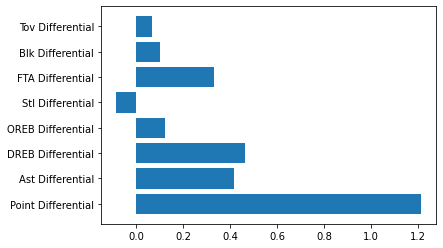

In [47]:
# Summary Statistics for all attributes
plt.barh(df_new.describe().columns, df_new.describe().iloc[1])
df_new.describe()

The bar graph displays the mean for each attribute - the home team has a slight lead in each attribute except the Steal differential. The point differential appears to be greater than the others but that is because points are scaled differently than the rest of the columns - we will perform standardization next.

<AxesSubplot:>

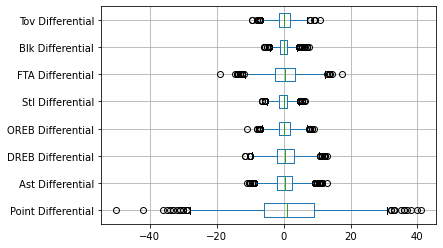

In [48]:
# Distribution of each attribute 
df_new.boxplot(vert=False)

The distribution of each attribute appears to be normally distributed with a mean centering around 0. This meets the normality assumption that allows us to scale the data, since the attributes are in different units (e.g. - point scored is different than rebounds or assists, and has a higher magnitude, which can be seen by it's distribution being wider.)

In [49]:
# Need to normalize variables, since they are different units and on different scales
scaler = StandardScaler()
scaler.fit(df_new)
scaled_features = scaler.transform(df_new)

## Model Building

To build our predictive model, we will use two algorithms: logistic regression and K-Nearest Neighbors. This problem is a binary classification problem - want to predict one of two classes: W or L - these two classes are the expected output from the models.

 ### 1. Creating Training and Testing Data

In [50]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, dfhome["WL_HOME"], test_size=0.30, random_state=101)

### 2. Building & Evaluating Logistic Regression Model

In [51]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
log_preds = logmodel.predict(X_test)
log_acc = accuracy_score(y_test,log_preds)
print(classification_report(y_test,log_preds))

              precision    recall  f1-score   support

           L       0.88      0.88      0.88       445
           W       0.90      0.90      0.90       554

    accuracy                           0.89       999
   macro avg       0.89      0.89      0.89       999
weighted avg       0.89      0.89      0.89       999



### 3. Building & Evaluating K-Nearest Neighbors Model
One of the difficulties with using a K-NN model is to decide on the parameter k. In order to optimize our model performance, we will start with a baseline of k = 1, and then use the elbow method to find the optimal k.

In [52]:
# Initial model: K = 1
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
knn_preds = knn.predict(X_test)
print(classification_report(y_test,knn_preds))

              precision    recall  f1-score   support

           L       0.77      0.77      0.77       445
           W       0.82      0.82      0.82       554

    accuracy                           0.80       999
   macro avg       0.80      0.80      0.80       999
weighted avg       0.80      0.80      0.80       999



With our baseline accuracy of 0.80, we will iterate through different values of k, from 1 through 39. We will calculate the accuracy scores for each of these models and append it to a list, where we will then plot the value of k with it's corresponding accuracy score.

Text(0, 0.5, 'Accuracy')

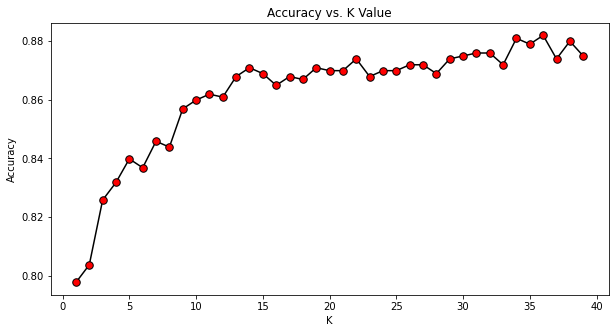

In [53]:
# Optimizing K

accuracy = []

# Creating different models with different values for k
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    acc_knn = accuracy_score(y_test, pred_i)
    accuracy.append(acc_knn)
    
# Plot    
plt.figure(figsize=(10,5))
plt.plot(range(1,40),accuracy,color='black', marker='.',
         markerfacecolor='red', markersize=15)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

The graph shows us that k-values after k = 15 seem to just randomly hover around an accuracy of 0.87. We prefer simpler models, so we will use K = 15. 

In [54]:
knn_15 = KNeighborsClassifier(n_neighbors=15)
knn_15.fit(X_train,y_train)
knn15_preds = knn.predict(X_test)
knn_acc = accuracy_score(y_test,knn15_preds)
print(classification_report(y_test,knn15_preds))

              precision    recall  f1-score   support

           L       0.88      0.83      0.86       445
           W       0.87      0.91      0.89       554

    accuracy                           0.87       999
   macro avg       0.88      0.87      0.87       999
weighted avg       0.88      0.87      0.87       999



In the end, by using the elbow method to optimize our k value, we ended with an accuracy score of 0.87, a 0.07 increase over our baseline, unoptimized k = 1 model. Now we will compare the accuracies of our logistic regression and K-NN model to come to a final conclusion of which model to use.

### 4. Final Model Evaluation

In [58]:
accuracies = [log_acc, knn_acc]
acc_df = pd.DataFrame({"Classifier": ["Logarithmic", "K-NN"],"Score": accuracies})
acc_df.sort_values("Score", ascending=False)

,Classifier,Score
0,Logarithmic,0.892893
1,K-NN,0.874875


A logistic regression model narrowly has a better accuracy score than the K-NN model. Therefore, the logistic regression model will be our model of choice for this problem.

## Conclusion
In summary, we extracted our data from a SQLite database and used a simple SQL query to retrieve data from after the 2018-2019 season. We performed data cleaning by removing nulls and converting the data to the appropriate data types. We did some simple feature engineering as well by calculatign new differential columns that measured the difference between the home and the away teams for various statistical categories - these would become our predictor variables. We then performed exploratory data analysis, exploring the biases and statistical properties of our predictor variables, and also standardized the data. Lastly, we applied both a logistic regression and a K-nearest neighbors model to the dataset, and concluded that the logistic regression model had better performance.

Using this model, gambling websites and companies can improve their live odds for NBA games after halftime. More accurate predictions of games will reduce discrepancies between the odds for a game and teh actual outcome, which will save the company money by reducing the payout amount they give due to inaccurate predictions on games.